# Predicción de datos temporales con Xgboost y Prophet

Para la predicción se utilizaron los datos Vegetation Indices (NDVI & EVI) obtenidos de la la aplicación  Application for Extracting and Exploring Analysis Ready Samples ([AρρEEARS](https://appeears.earthdatacloud.nasa.gov/)).

El rango de tiempo seleccionado fue desde el 01-01-2000 al presente.

**Product id**: MOD13A3-061
**Layer**: 1_km_monthly_NDVI

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# 1.  Vegetation Indices (NDVI & EVI) data

## Data join

In [118]:
import pandas as pd
import os

In [119]:
folder_path = '/content/drive/MyDrive/NASA Space APP Challenge/ET data csv/'  # Update with your actual folder path
all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
print(all_files)

['MOD16A2.061_20200101_to_20231230-Statistics.csv', 'MOD16A2-061-Statistics.csv']


In [120]:
df_list = []

for file_name in all_files:
    file_path = os.path.join(folder_path, file_name)

    df = pd.read_csv(file_path)
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)
combined_df.head()

,File Name,Dataset,aid,Date,Count,Minimum,Maximum,Range,Mean,Standard Deviation,Variance,Upper Quartile,Upper 1.5 IQR,Median,Lower 1.5 IQR,Lower Quartile
0,MOD16A2_061_ET_500m_doy2021001_aid0001,ET_500m,aid0001,2021-01-01,30152.0,2.3,7.4,"(2.3,7.4)",4.540193,1.287675,1.658106,5.5,7.4,4.8,2.3,3.3
1,MOD16A2_061_ET_500m_doy2021009_aid0001,ET_500m,aid0001,2021-01-09,30152.0,1.4,5.4,"(1.4,5.4)",3.282058,1.023526,1.047605,4.0,5.4,3.6,1.4,2.2
2,MOD16A2_061_ET_500m_doy2021017_aid0001,ET_500m,aid0001,2021-01-17,30152.0,3.9,8.1,"(3.9,8.1)",6.061435,0.664382,0.441404,6.6,8.1,6.0,4.1,5.6
3,MOD16A2_061_ET_500m_doy2021025_aid0001,ET_500m,aid0001,2021-01-25,30152.0,0.0,9.0,"(0.0,9.0)",6.923803,0.759336,0.576592,7.5,9.0,6.9,4.8,6.4
4,MOD16A2_061_ET_500m_doy2021033_aid0001,ET_500m,aid0001,2021-02-02,30152.0,2.5,4.7,"(2.5,4.7)",3.583782,0.410411,0.168437,3.9,4.7,3.6,2.5,3.3


In [121]:
num_rows, num_columns = combined_df.shape

print(f"Number of data points (rows): {num_rows}")
print(f"Number of columns: {num_columns}")

Number of data points (rows): 185
Number of columns: 16


In [124]:
#combined_df.to_csv('/content/drive/MyDrive/NASA Space APP Challenge/NDVI data csv/combined_dataset.csv', index=False)
combined_df.to_csv('/content/drive/MyDrive/NASA Space APP Challenge/ET data csv/combined_dataset.csv', index=False)

In [125]:
file_path = '/content/drive/MyDrive/NASA Space APP Challenge/ET data csv/combined_dataset.csv'  # Update with your CSV path
data = pd.read_csv(file_path)
data.head()

,File Name,Dataset,aid,Date,Count,Minimum,Maximum,Range,Mean,Standard Deviation,Variance,Upper Quartile,Upper 1.5 IQR,Median,Lower 1.5 IQR,Lower Quartile
0,MOD16A2_061_ET_500m_doy2021001_aid0001,ET_500m,aid0001,2021-01-01,30152.0,2.3,7.4,"(2.3,7.4)",4.540193,1.287675,1.658106,5.5,7.4,4.8,2.3,3.3
1,MOD16A2_061_ET_500m_doy2021009_aid0001,ET_500m,aid0001,2021-01-09,30152.0,1.4,5.4,"(1.4,5.4)",3.282058,1.023526,1.047605,4.0,5.4,3.6,1.4,2.2
2,MOD16A2_061_ET_500m_doy2021017_aid0001,ET_500m,aid0001,2021-01-17,30152.0,3.9,8.1,"(3.9,8.1)",6.061435,0.664382,0.441404,6.6,8.1,6.0,4.1,5.6
3,MOD16A2_061_ET_500m_doy2021025_aid0001,ET_500m,aid0001,2021-01-25,30152.0,0.0,9.0,"(0.0,9.0)",6.923803,0.759336,0.576592,7.5,9.0,6.9,4.8,6.4
4,MOD16A2_061_ET_500m_doy2021033_aid0001,ET_500m,aid0001,2021-02-02,30152.0,2.5,4.7,"(2.5,4.7)",3.583782,0.410411,0.168437,3.9,4.7,3.6,2.5,3.3


## Modelo 1 [xgboost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

target_column = 'Mean'

data['Month'] = pd.to_datetime(data['Date']).dt.month
data['Year'] = pd.to_datetime(data['Date']).dt.year

feature_columns = [
    'Month','Year','Minimum', 'Maximum', 'Variance', 'Upper Quartile',
    'Lower Quartile', 'Standard Deviation', 'Median', 'Upper 1.5 IQR', 'Lower 1.5 IQR'
]

X = data[feature_columns]
y = data[target_column]

# 80% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [56]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10,
}

In [57]:
bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], early_stopping_rounds=10)

# Predict on the test set
y_pred = bst.predict(dtest)

# Evaluate performance
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {mse}")

[0]	test-rmse:0.01789
[1]	test-rmse:0.01789
[2]	test-rmse:0.01789
[3]	test-rmse:0.01789
[4]	test-rmse:0.01789
[5]	test-rmse:0.01789
[6]	test-rmse:0.01789
[7]	test-rmse:0.01789
[8]	test-rmse:0.01789
[9]	test-rmse:0.01789
Test Mean Squared Error: 0.000320200227672056


## Modelo 2 xgboost

In [77]:
# XGBoost regressor model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=100)

xg_reg.fit(X_train, y_train, verbose=True)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [78]:
# Predictions on test set
y_pred = xg_reg.predict(X_test)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse}")

Mean Squared Error on Test Set: 0.000320200227672056


## Modelo 3 [Prophet](https://facebook.github.io/prophet/)

In [60]:
!pip install prophet

In [73]:
import pandas as pd
from prophet import Prophet

data['Month'] = pd.to_datetime(data['Date']).dt.month
data['Year'] = pd.to_datetime(data['Date']).dt.year

data['ds'] = pd.to_datetime(data[['Year', 'Month']].assign(day=1))
data['y'] = data['Mean']

prophet_data = data[['ds', 'y']]

model = Prophet()
model.fit(prophet_data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfy35cs8m/m8jirwrt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfy35cs8m/36mj2dsi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74155', 'data', 'file=/tmp/tmpfy35cs8m/m8jirwrt.json', 'init=/tmp/tmpfy35cs8m/36mj2dsi.json', 'output', 'file=/tmp/tmpfy35cs8m/prophet_modelh204ksyw/prophet_model-20241006134108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:41:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:41:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [76]:
future_dates = pd.DataFrame({
    'year': [2025, 2030, 2025, 2030],  # years
    'month': [1,1,6,6]           # months
})

future_dates['ds'] = pd.to_datetime(future_dates[['year', 'month']].assign(day=1))

forecast = model.predict(future_dates[['ds']])

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])  # yhat is the predicted value

          ds      yhat  yhat_lower  yhat_upper
0 2025-01-01  0.245449    0.230009    0.261576
1 2025-06-01  0.247422    0.231755    0.263338
2 2030-01-01  0.241434    0.226466    0.257525
3 2030-06-01  0.246608    0.230761    0.261769


In [90]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
624,2023-11-27
625,2023-11-28
626,2023-11-29
627,2023-11-30
628,2023-12-01


In [92]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
624,2023-11-27,0.295149,0.278252,0.310934
625,2023-11-28,0.291158,0.274807,0.307431
626,2023-11-29,0.285990,0.270393,0.301655
627,2023-11-30,0.279682,0.263498,0.294479
628,2023-12-01,0.272299,0.255876,0.288547


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


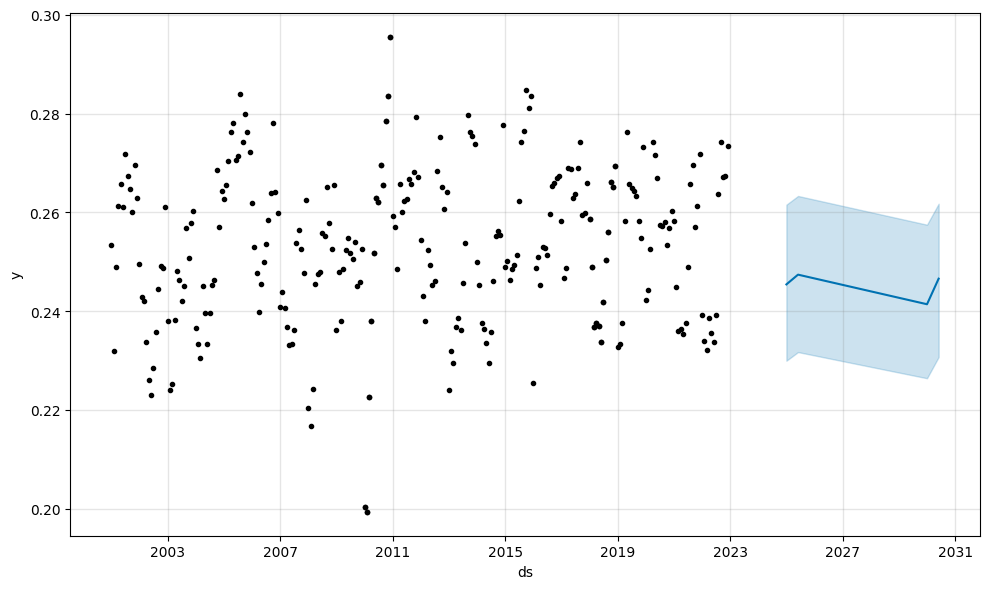

In [87]:
fig1 = model.plot(forecast)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

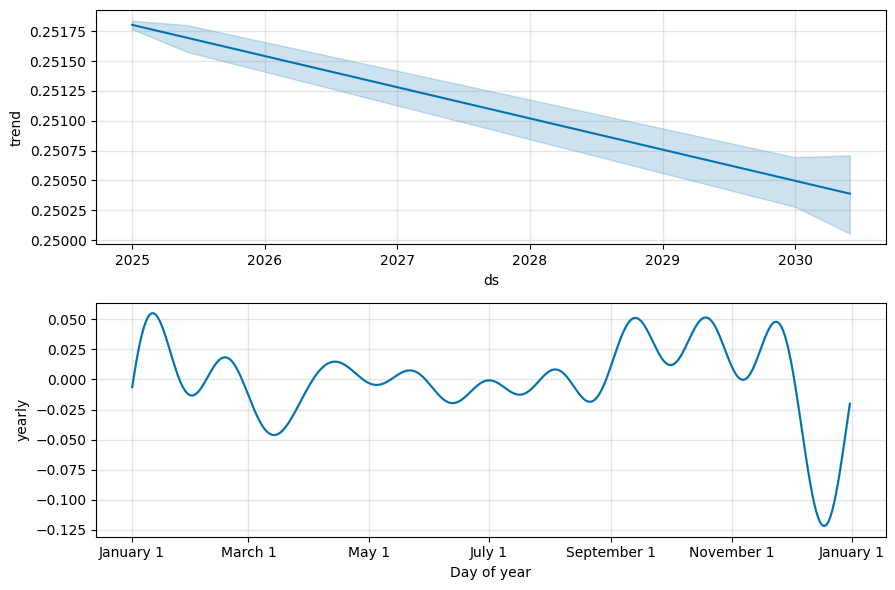

In [89]:
fig2 = model.plot_components(forecast)

## Modelo final Prophet

In [126]:
from prophet import Prophet

#model = Prophet()
model = Prophet(seasonality_mode='multiplicative')
# Date	Count	Minimum	Maximum	Range	Mean	Standard Deviation	Variance	Upper Quartile	Upper 1.5 IQR	Median	Lower 1.5 IQR	Lower Quartile

model.add_regressor('Minimum')
model.add_regressor('Maximum')
model.add_regressor('Variance')
model.add_regressor('Standard Deviation')
model.add_regressor('Median')

data['ds'] = data['Date']
data['y'] = data['Mean']

model.fit(data[['ds', 'y', 'Minimum', 'Maximum', 'Variance','Standard Deviation','Median']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfy35cs8m/ululsiiz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfy35cs8m/dhp6nh_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19261', 'data', 'file=/tmp/tmpfy35cs8m/ululsiiz.json', 'init=/tmp/tmpfy35cs8m/dhp6nh_z.json', 'output', 'file=/tmp/tmpfy35cs8m/prophet_models8hcrjv8/prophet_model-20241006152705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:27:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:27:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


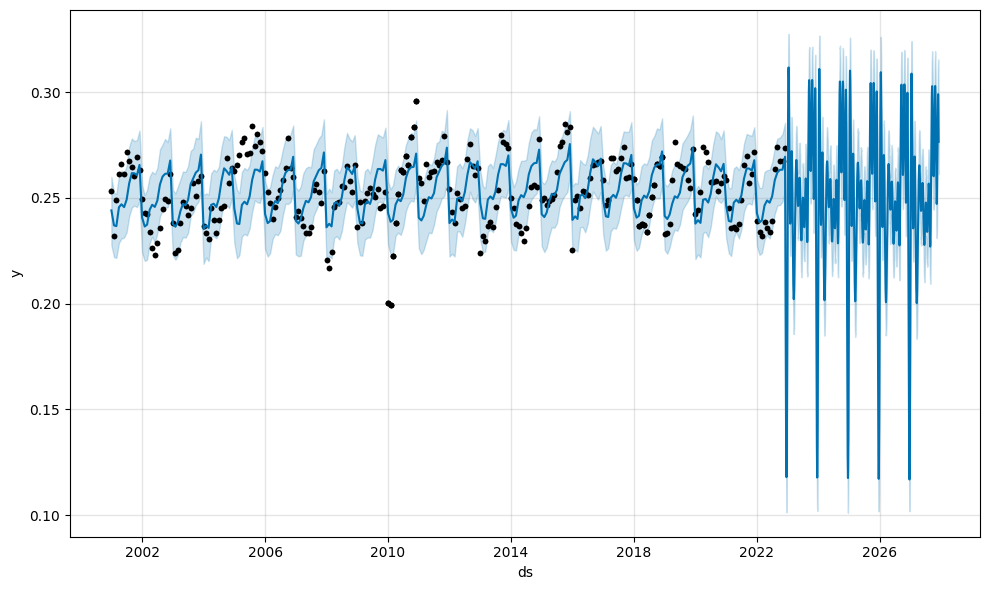

In [127]:
future = m.make_future_dataframe(periods=1825)
fcst = m.predict(future)
fig = m.plot(fcst)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

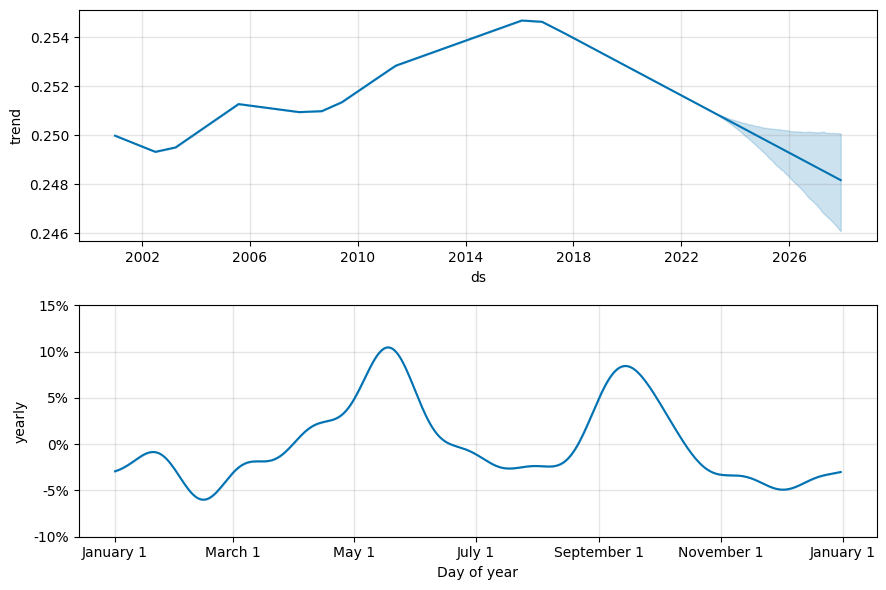

In [128]:
fig2 = model.plot_components(fcst)

In [106]:
# Future dates for the next 12 months
future_dates = model.make_future_dataframe(periods=12, freq='M')

future_dates['Minimum'] = df['Minimum'].mean()
future_dates['Maximum'] = df['Maximum'].mean()
future_dates['Variance'] = df['Variance'].mean()
future_dates['Standard Deviation'] = df['Standard Deviation'].mean()
future_dates['Median'] = df['Median'].mean()

forecast = model.predict(future_dates)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

            ds      yhat  yhat_lower  yhat_upper
0   2001-01-01  0.255508    0.253717    0.257333
1   2001-02-01  0.255677    0.253702    0.257808
2   2001-03-01  0.256966    0.255187    0.258938
3   2001-04-01  0.255593    0.253792    0.257615
4   2001-05-01  0.253747    0.252000    0.255557
..         ...       ...         ...         ...
271 2023-07-31  0.250951    0.248983    0.252822
272 2023-08-31  0.251235    0.249136    0.253131
273 2023-09-30  0.254276    0.252284    0.256187
274 2023-10-31  0.256642    0.254515    0.258623
275 2023-11-30  0.254180    0.252167    0.256210

[276 rows x 4 columns]


/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [116]:
from prophet.serialize import model_to_json, model_from_json

with open('/content/drive/MyDrive/NASA Space APP Challenge/NDVI data/serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

with open('/content/drive/MyDrive/NASA Space APP Challenge/NDVI data/serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

In [85]:
data.tail()

,File Name,Dataset,aid,Date,Count,Minimum,Maximum,Range,Mean,Standard Deviation,Variance,Upper Quartile,Upper 1.5 IQR,Median,Lower 1.5 IQR,Lower Quartile
283,MOD13A3_061__1_km_monthly_NDVI_doy2010213_aid0001,_1_km_monthly_NDVI,aid0001,2010-08-01,7969.0,0.1029,0.7718,"(0.1029,0.7718)",0.269643,0.131796,0.017370,0.3073,0.4908,0.2122,0.1029,0.1849
284,MOD13A3_061__1_km_monthly_NDVI_doy2010244_aid0001,_1_km_monthly_NDVI,aid0001,2010-09-01,7969.0,0.0830,0.7275,"(0.083,0.7275)",0.265637,0.125706,0.015802,0.3088,0.4962,0.2117,0.0830,0.1838
285,MOD13A3_061__1_km_monthly_NDVI_doy2010274_aid0001,_1_km_monthly_NDVI,aid0001,2010-10-01,7969.0,0.1260,0.6423,"(0.126,0.6423)",0.278585,0.116395,0.013548,0.3317,0.5362,0.2299,0.1260,0.1953
286,MOD13A3_061__1_km_monthly_NDVI_doy2010305_aid0001,_1_km_monthly_NDVI,aid0001,2010-11-01,7969.0,0.1265,0.6550,"(0.1265,0.655)",0.283501,0.104271,0.010872,0.3360,0.5239,0.2409,0.1265,0.2107
287,MOD13A3_061__1_km_monthly_NDVI_doy2010335_aid0001,_1_km_monthly_NDVI,aid0001,2010-12-01,7969.0,0.0413,0.7565,"(0.0413,0.7565)",0.295592,0.108777,0.011832,0.3507,0.5479,0.2553,0.0413,0.2192
